In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import requests 
import pandas as pd
from bs4 import BeautifulSoup
import time

In [2]:
# if failed, it is due to outdated of chrome driver
# please follow install guide in C:\Software\chromedriver directory
# Current version of chrome driver in use is 120

service = Service('C:\\Software\\chromedriver\\chromedriver.exe')
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)


driver.get("https://bet.hkjc.com/marksix/Results.aspx?lang=en")
time.sleep(10)

In [3]:
html2=driver.page_source
text_non2 = html2.replace("\n","")
bsObj2 = BeautifulSoup(text_non2, "html.parser")
histDrawResults=bsObj2.find_all("div", { "class" : "resultMainRow"} )
#histDrawResults

In [4]:
allHistDR = []
for hdr in histDrawResults:
    eachHistDR = {}
    drawId = ""
    for idx, hdrc in enumerate(hdr.children):
        if idx == 0:
            drawId = hdrc.find("a").get_text()
            eachHistDR["drawId"]=drawId[0:6]
        if idx == 1:
            drawDate = hdrc.get_text()    
            eachHistDR["drawDate"]=drawDate
        if idx == 3:
            #print(hdrc)
            eachDR = []
            for idxe, r in enumerate(hdrc.children):
                srce = r.find("img").get("src")
                noe=srce[srce.find("_")+1 : srce.find("_s.gif") ]
                if idxe == 6:
                    noe = "+"
                eachDR.append(noe)
            #eachHistDR["drawNumber"]=eachDR
            eachHistDR["1st"]=eachDR[0]
            eachHistDR["2nd"]=eachDR[1]
            eachHistDR["3rd"]=eachDR[2]
            eachHistDR["4th"]=eachDR[3]
            eachHistDR["5th"]=eachDR[4]
            eachHistDR["6th"]=eachDR[5]
            eachHistDR["SPNo"]=eachDR[7]
    allHistDR.append(eachHistDR)
#for i in allHistDR:
#    print(i)
df=pd.DataFrame.from_records(allHistDR)
df


,drawId,drawDate,1st,2nd,3rd,4th,5th,6th,SPNo
0,24/008,20/01/2024,03,25,31,40,43,48,45
1,24/007,18/01/2024,02,10,17,46,47,49,03
2,24/006,16/01/2024,01,06,08,27,41,47,29
3,24/005,14/01/2024,03,17,18,36,38,39,21
4,24/004,11/01/2024,03,06,08,26,29,38,01
5,24/003,09/01/2024,03,09,16,19,33,35,39
6,24/002,06/01/2024,01,04,24,31,33,34,02
7,24/001,03/01/2024,02,03,19,34,37,46,32
8,23/146,30/12/2023,05,08,19,25,41,48,24
9,23/145,28/12/2023,11,18,27,29,34,45,28


In [5]:
driver.quit()

In [6]:
from pymongo import MongoClient
from pymongo.errors import OperationFailure

In [7]:
url = 'mongodb://localhost:27017'
client = MongoClient(url)

try:
    db = client['mydb']
    collection = db['marksix']
    
    for index, row in df.iterrows():
        drawId=row['drawId']
        
        if collection.count_documents({'drawId' :drawId}) == 0:
            rec_id1 = collection.insert_one(row.to_dict())
            print(f"Draw ID : {drawId} Inserting...")
        #print(rec_id1)
        #print(row.to_dict())
    print("Import Ended\n")
    
    list_cur = list(collection.find().sort('drawId', -1))
    df_ms_hist = pd.DataFrame(list_cur)
    df_ms_hist = df_ms_hist[['drawId','drawDate', '1st', '2nd', '3rd', '4th', '5th', '6th', 'SPNo']]
    #print(df_ms_hist)

except OperationFailure as e:
    print(f"Error:\n {e}")
finally:
    client.close()

Draw ID : 24/008 Inserting...
Draw ID : 24/007 Inserting...
Draw ID : 24/006 Inserting...
Draw ID : 24/005 Inserting...
Draw ID : 24/004 Inserting...
Draw ID : 24/003 Inserting...
Draw ID : 24/002 Inserting...
Draw ID : 24/001 Inserting...
Draw ID : 23/146 Inserting...
Draw ID : 23/145 Inserting...
Import Ended



In [8]:
df_ms_hist

,drawId,drawDate,1st,2nd,3rd,4th,5th,6th,SPNo
0,24/008,20/01/2024,03,25,31,40,43,48,45
1,24/007,18/01/2024,02,10,17,46,47,49,03
2,24/006,16/01/2024,01,06,08,27,41,47,29
3,24/005,14/01/2024,03,17,18,36,38,39,21
4,24/004,11/01/2024,03,06,08,26,29,38,01
...,...,...,...,...,...,...,...,...,...
66,23/082,25/07/2023,01,02,10,13,29,47,09
67,23/081,20/07/2023,04,16,18,34,35,46,47
68,23/080,18/07/2023,15,16,34,36,39,40,42
69,23/079,15/07/2023,04,09,12,33,37,42,03


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

Text(0, 0.5, 'Draw ID')

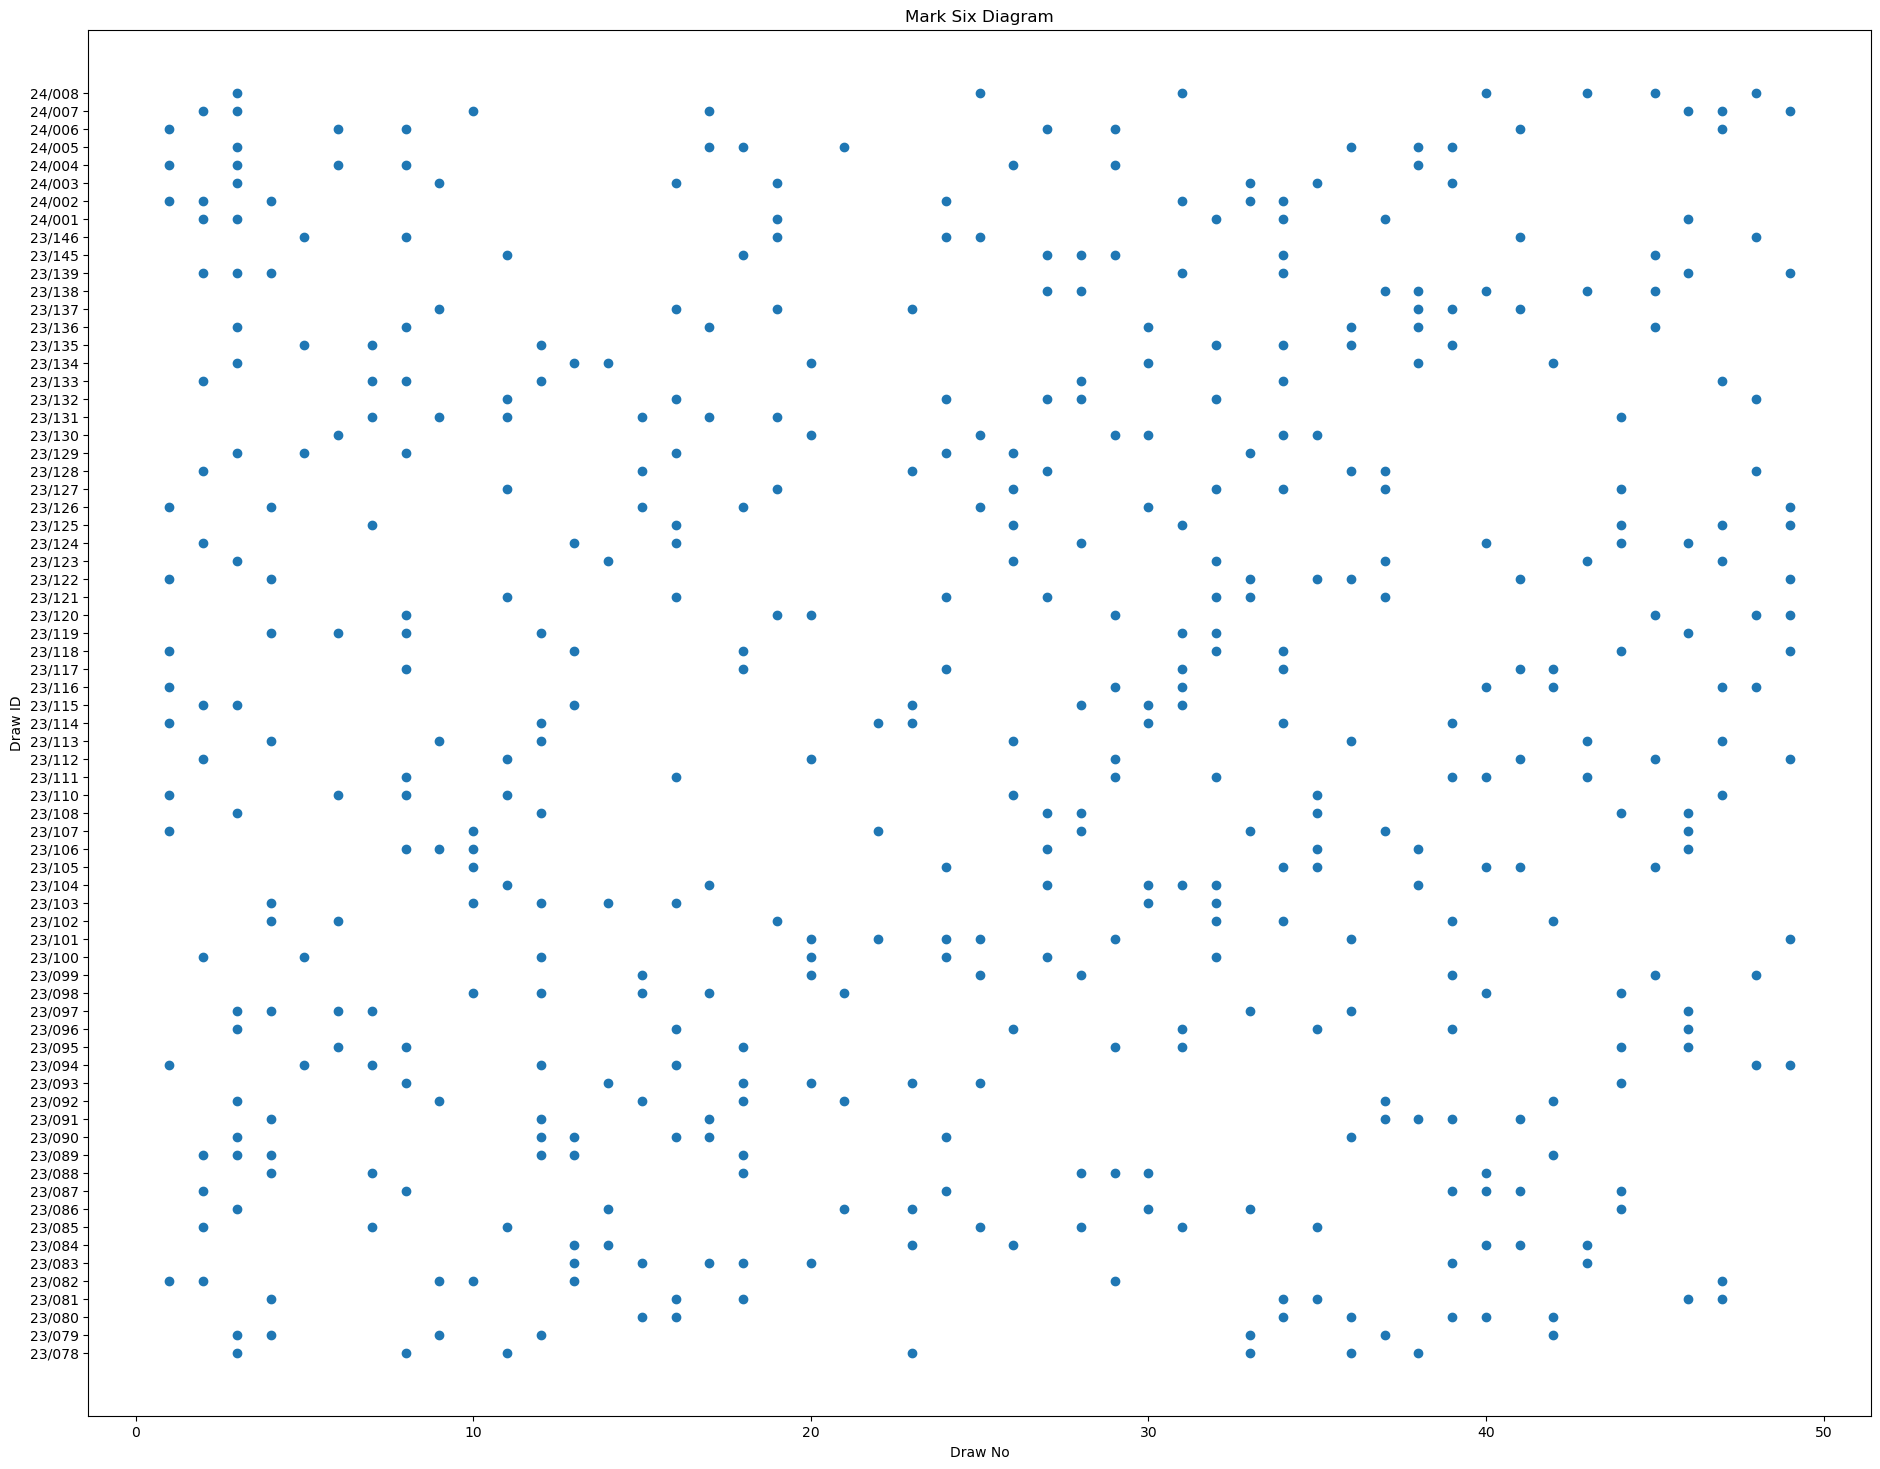

In [15]:
url = 'mongodb://localhost:27017'
client = MongoClient(url)

db = client['mydb']
collection = db['marksix']

list_cur = list(collection.find().limit(100).sort('drawId', 1))
df_ms_hist = pd.DataFrame(list_cur)
cols=list(df_ms_hist.columns)

L=[]
for index, row in df_ms_hist.iterrows():
    drawId=row[cols[1]]
    for i in range(7):
        D={}
        D['drawId']=drawId
        D['drawNo']=int(row[cols[i+3]])
        L.append(D)
df_ms_output=pd.DataFrame.from_records(L)

# create a figure and axis
#fig, ax = plt.subplots(figsize=(12,5))
#fig, ax = plt.subplots(figsize=(13,7))
fig, ax = plt.subplots(figsize=(23,18))

# scatter the sepal_length against the sepal_width
#ax.scatter(df_ms_output['drawId'], df_ms_output['drawNo'])
ax.scatter(df_ms_output['drawNo'], df_ms_output['drawId'])
# set a title and labels
ax.set_title('Mark Six Diagram')
ax.set_xlabel('Draw No')
ax.set_ylabel('Draw ID')

In [11]:
client.close()